In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')

In [3]:
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [5]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

In [6]:
train_df['DepHour'] = train_df['DepTime'] // 100
train_df['DepHour'].replace(to_replace=24, value=0, inplace=True)

test_df['DepHour'] = test_df['DepTime'] // 100
test_df['DepHour'].replace(to_replace=24, value=0, inplace=True)

train_df['DepMinutes'] = train_df['DepTime'] % 100
test_df['DepMinutes'] = test_df['DepTime'] % 100

In [7]:
train_df['Month'] = train_df['Month'].str[2:].astype('int')
train_df['DayofMonth'] = train_df['DayofMonth'].str[2:].astype('int')
train_df['DayOfWeek'] = train_df['DayOfWeek'].str[2:].astype('int')


test_df['Month'] = test_df['Month'].str[2:].astype('int')
test_df['DayofMonth'] = test_df['DayofMonth'].str[2:].astype('int')
test_df['DayOfWeek'] =test_df['DayOfWeek'].str[2:].astype('int')

In [8]:
df_delay = train_df[train_df['dep_delayed_15min']=='Y']
df_not_delay = train_df[train_df['dep_delayed_15min']=='N']

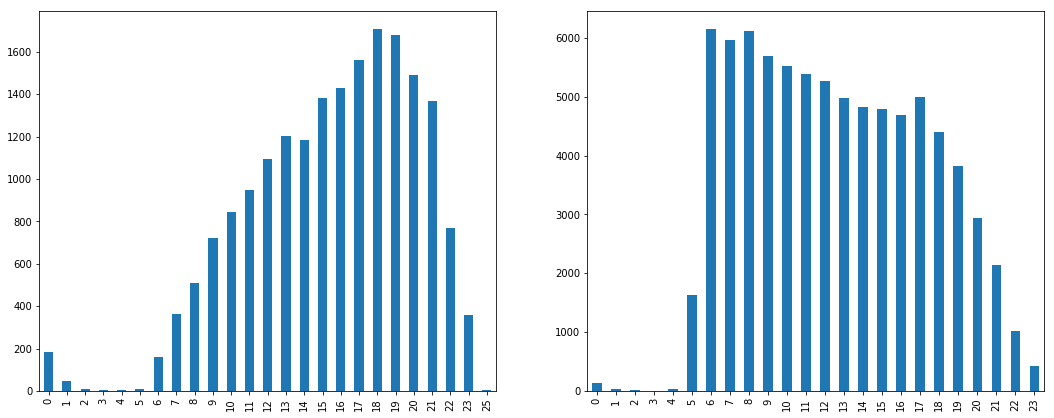

In [9]:
plt.figure(figsize=(18,7));
plt.subplot(1,2,1);
df_delay['DepHour'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,2,2);
df_not_delay['DepHour'].value_counts().sort_index().plot(kind='bar');

In [10]:
def minute_4_part(x):
    for i in range(4):
        if x >= i*15 and x < (i+1)*15:
            return i+1

In [11]:
train_df['all_part_time'] = train_df['DepHour']*4+train_df['DepMinutes'].apply(minute_4_part)
test_df['all_part_time'] = test_df['DepHour']*4+test_df['DepMinutes'].apply(minute_4_part)

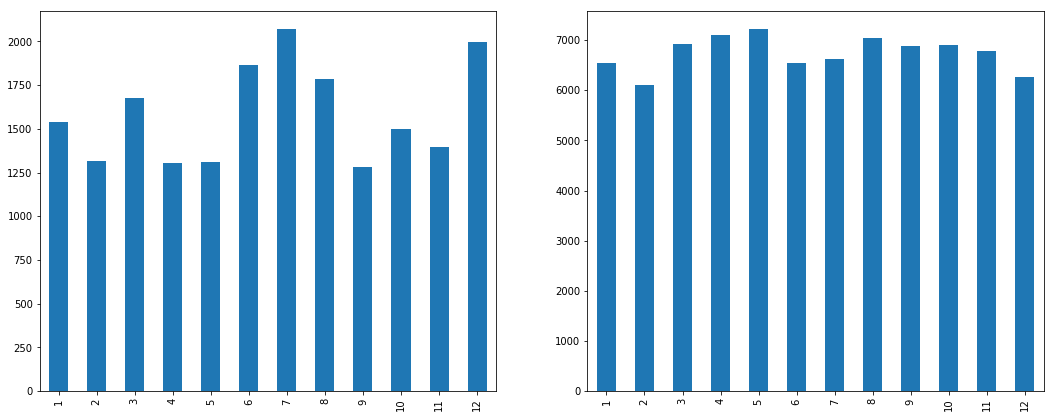

In [12]:
plt.figure(figsize=(18,7));
plt.subplot(1,2,1);
df_delay['Month'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,2,2);
df_not_delay['Month'].value_counts().sort_index().plot(kind='bar');

In [13]:
def month_peak(x):
    if x==12 or x==6 or x==7:
        return  0 
    elif x==4 or x==5 or x==9 or x==2:
        return 1 
    else:
        return 2 

In [14]:
train_df['month_peak'] = train_df['Month'].apply(month_peak)

test_df['month_peak'] = test_df['Month'].apply(month_peak)

In [15]:
def season(x):
    if x==12 or x==1 or x==2:
        return  0 #winter
    elif x>=3 and x<=5:
        return 1 #spring
    elif x>=6 and x<=8:
        return 2 #summer
    elif x>=9 and x<=11:
        return 3 #autunm

In [16]:
train_df['season_time'] = train_df['Month'].apply(season)

test_df['season_time'] = test_df['Month'].apply(season)

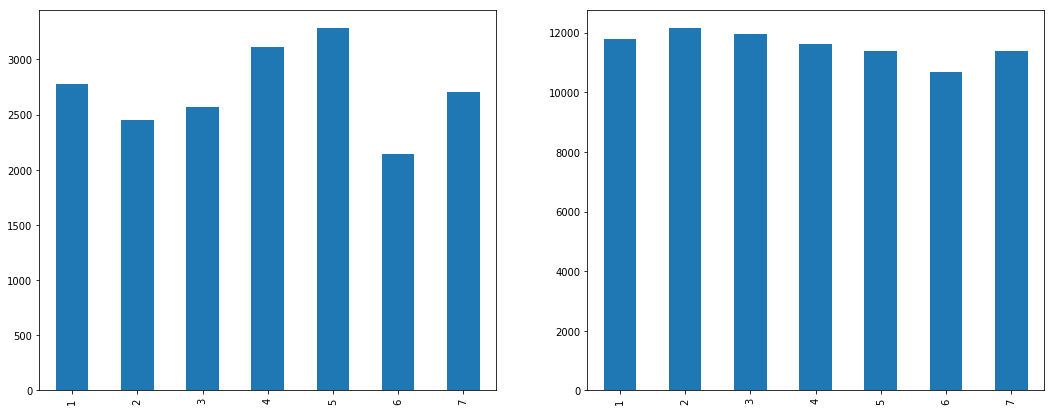

In [17]:
plt.figure(figsize=(18,7));
plt.subplot(1,2,1);
df_delay['DayOfWeek'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,2,2);
df_not_delay['DayOfWeek'].value_counts().sort_index().plot(kind='bar');

In [18]:
def traffic_week(x):
    if x==1 or x==4 or x==5 or x==7:
        return 1 #hight_delay
    else:
        return 0 #low_delay

In [19]:
train_df['traffic_week'] = train_df['DayOfWeek'].apply(traffic_week)

test_df['traffic_week'] = test_df['DayOfWeek'].apply(traffic_week)

In [20]:
train_df['dep_delayed_15min'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

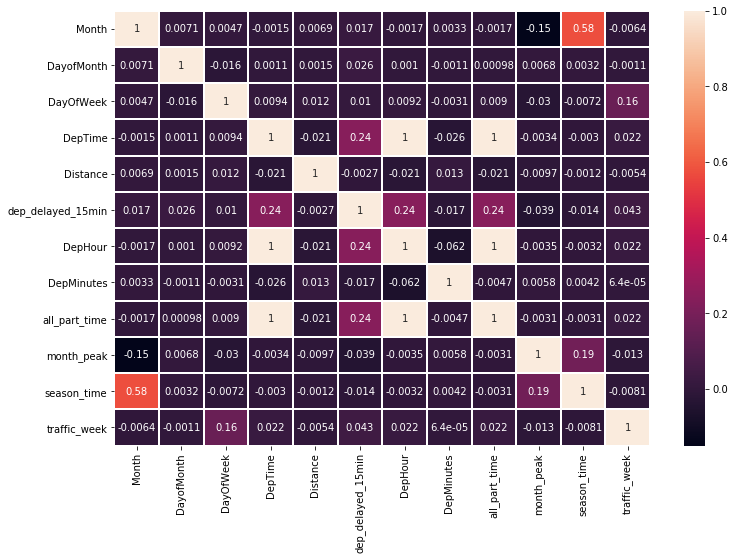

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), linewidths=1, annot=True);

In [22]:
train_df['Month'] = train_df['Month'].astype('object')
test_df['Month'] = test_df['Month'].astype('object')

train_df['DepHour'] = train_df['DepHour'].astype('object')
test_df['DepHour'] = test_df['DepHour'].astype('object')


train_df['month_peak'] = train_df['month_peak'].astype('object')
test_df['month_peak'] = test_df['month_peak'].astype('object')

train_df['season_time'] = train_df['season_time'].astype('object')
test_df['season_time'] = test_df['season_time'].astype('object')

train_df['traffic_week']=train_df['traffic_week'].astype('object')
test_df['traffic_week']=test_df['traffic_week'].astype('object')

train_df['all_part_time']=train_df['all_part_time'].astype('object')
test_df['all_part_time']=test_df['all_part_time'].astype('object')

In [23]:
colstodel = ['dep_delayed_15min']
categ_feat_idx = np.where(train_df.drop(columns = colstodel, axis=1).dtypes == 'object')[0]
categ_feat_idx

array([ 0,  4,  5,  6,  8,  9, 11, 12, 13, 14])

In [24]:
train_df.drop(columns = colstodel, axis=1).head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,flight,DepHour,DepMinutes,all_part_time,month_peak,season_time,traffic_week
0,8,21,7,1934,AA,ATL,DFW,732,ATL-->DFW,19,34,79,2,2,1
1,4,20,3,1548,US,PIT,MCO,834,PIT-->MCO,15,48,64,1,1,0
2,9,2,5,1422,XE,RDU,CLE,416,RDU-->CLE,14,22,58,1,3,1
3,11,25,6,1015,OO,DEN,MEM,872,DEN-->MEM,10,15,42,2,3,0
4,10,7,6,1828,WN,MDW,OMA,423,MDW-->OMA,18,28,74,2,3,0


In [25]:
X_train = train_df.drop(columns = colstodel, axis=1).values
y_train = train_df['dep_delayed_15min']
X_test = test_df.drop(columns = colstodel[1:], axis=1).values

In [26]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [27]:
ctb = CatBoostClassifier(iterations=5000,
                          
                          eval_metric='AUC',
                          max_depth=None,
                          random_seed=17, 
                          silent=True)

In [28]:
%%time
ctb.fit(X_train_part, y_train_part, 
         eval_set=(X_valid, y_valid),
         cat_features=categ_feat_idx,
         plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 46min 4s, sys: 3min 50s, total: 49min 55s
Wall time: 14min 16s


In [29]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

In [30]:
roc_auc_score(y_valid, ctb_valid_pred)

0.8087586935158355

In [31]:
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);
ctb_test_pred_1 = ctb.predict_proba(X_test)[:, 1]

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred_1
    sample_sub.to_csv('ctb_pred_last_3000.csv')